In [23]:
import pandas as pd

# Load the data from the provided files
bus_data_path = 'MBTA_Bus_Routes_and_Stops.csv'
cities_data_path = 'cities_and_towns.xlsx'

# Read the data into pandas dataframes
bus_data = pd.read_csv('MBTA_Bus_Routes_and_Stops.csv')
cities_data = pd.read_excel(cities_data_path)
mbta_data = pd.read_csv('MBTA.csv')

In [6]:
bus_stop_counts = bus_data['MBTA_Bus_Routes_and_Stops'][1:].value_counts().reset_index()
bus_stop_counts.columns = ['Municipality', 'Bus_Stop_Count']

# Merge with the cities data to get the community type for each municipality
merged_data = pd.merge(bus_stop_counts, cities_data[['Municipality', 'Type']], on='Municipality', how='left')

In [7]:
unique_bus_municipalities = set(bus_stop_counts['Municipality'].unique())
unique_cities_municipalities = set(cities_data['Municipality'].unique())

# Finding municipalities that are in the bus data but not in the cities data
mismatched_municipalities = unique_bus_municipalities - unique_cities_municipalities

In [8]:
matched_data = merged_data.dropna(subset=['Type'])

# Grouping by community type and calculating the average number of bus stops
average_bus_stops_per_type = matched_data.groupby('Type')['Bus_Stop_Count'].mean().reset_index()

In [9]:
# Finding the intersection of the municipality names between the two datasets
matched_municipalities = unique_bus_municipalities & unique_cities_municipalities

# Filtering the bus stop counts data to include only the matched municipalities
matched_bus_stop_counts = bus_stop_counts[bus_stop_counts['Municipality'].isin(matched_municipalities)]

# Merging this filtered data with the cities data to get the community types
matched_merged_data = pd.merge(matched_bus_stop_counts, cities_data[['Municipality', 'Type']], on='Municipality', how='left')

# Grouping by community type and calculating the average number of bus stops
average_bus_stops_per_type = matched_merged_data.groupby('Type')['Bus_Stop_Count'].mean().reset_index()

In [12]:
from fuzzywuzzy import process

# Using fuzzy matching to find the best matches for each municipality in the bus data
# against the municipalities in the cities data
def get_best_match(municipality, choices, cutoff=80):
    match, score = process.extractOne(municipality, choices)
    return match if score >= cutoff else None

# Applying fuzzy matching to the bus stop counts data
bus_stop_counts['Best_Match'] = bus_stop_counts['Municipality'].apply(
    lambda x: get_best_match(x, unique_cities_municipalities)
)

# Filtering out rows without a fuzzy match
fuzzy_matched_bus_stops = bus_stop_counts.dropna(subset=['Best_Match'])

# Merging the fuzzy matched bus stop counts with the cities data
fuzzy_matched_data = pd.merge(
    fuzzy_matched_bus_stops, 
    cities_data[['Municipality', 'Type']], 
    left_on='Best_Match', 
    right_on='Municipality',
    how='left'
)

# Grouping by community type and calculating the average number of bus stops
average_bus_stops_per_type_fuzzy = fuzzy_matched_data.groupby('Type')['Bus_Stop_Count'].mean().reset_index()

average_bus_stops_per_type_fuzzy

,Type,Bus_Stop_Count
0,City,265.782609
1,Town,58.482759


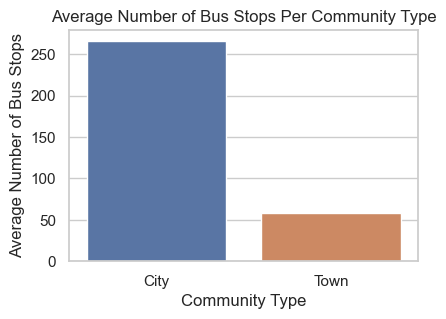

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the aesthetics for the graph
sns.set(style="whitegrid")

# Creating a bar graph
plt.figure(figsize=(4.5, 3))
barplot = sns.barplot(x='Type', y='Bus_Stop_Count', data=average_bus_stops_per_type_fuzzy)

# Setting the title and labels
plt.title('Average Number of Bus Stops Per Community Type')
plt.xlabel('Community Type')
plt.ylabel('Average Number of Bus Stops')

# Displaying the graph
plt.show()

In [15]:
import numpy as np

income_data = pd.read_excel(cities_data_path)

In [19]:
def categorize_by_income_range(income, col_name):
    if col_name in ['Median household income', 'Median family income'] and income >= 250000:
        return '250,000+'
    elif income >= income_data[col_name].median():
        return 'Above Median'
    else:
        return 'Below Median'


# Function to convert income values to float
def convert_income_to_float(income_str):
    if isinstance(income_str, str):
        income_str = income_str.replace('$', '').replace(',', '')
        if '+' in income_str:
            income_str = income_str.replace('+', '')
        return float(income_str)
    return income_str

# Converting income columns
income_data['Per capita income'] = income_data['Per capita income'].apply(convert_income_to_float)
income_data['Median household income'] = income_data['Median household income'].apply(convert_income_to_float)
income_data['Median family income'] = income_data['Median family income'].apply(convert_income_to_float)

# Recategorizing the data based on the new income thresholds
income_data['Per Capita Income Group'] = income_data['Per capita income'].apply(lambda x: categorize_by_income_range(x, 'Per capita income'))
income_data['Median Household Income Group'] = income_data['Median household income'].apply(lambda x: categorize_by_income_range(x, 'Median household income'))
income_data['Median Family Income Group'] = income_data['Median family income'].apply(lambda x: categorize_by_income_range(x, 'Median family income'))

# Checking the distribution in each categorized group
per_capita_income_distribution = income_data['Per Capita Income Group'].value_counts()
median_household_income_distribution = income_data['Median Household Income Group'].value_counts()
median_family_income_distribution = income_data['Median Family Income Group'].value_counts()

In [21]:
# Preparing the data for merging
income_categorized_data = income_data[['Municipality', 'Per Capita Income Group', 'Median Household Income Group', 'Median Family Income Group']]

# Merging with the bus stop data (using the fuzzy matched bus stop data)
merged_bus_income_data = pd.merge(
    fuzzy_matched_data[['Best_Match', 'Bus_Stop_Count']],
    income_categorized_data,
    left_on='Best_Match',
    right_on='Municipality',
    how='left'
)

# Grouping by income type and summing the bus stop counts for each income type
bus_stops_per_capita_income = merged_bus_income_data.groupby('Per Capita Income Group')['Bus_Stop_Count'].sum().reset_index()
bus_stops_median_household_income = merged_bus_income_data.groupby('Median Household Income Group')['Bus_Stop_Count'].sum().reset_index()
bus_stops_median_family_income = merged_bus_income_data.groupby('Median Family Income Group')['Bus_Stop_Count'].sum().reset_index()

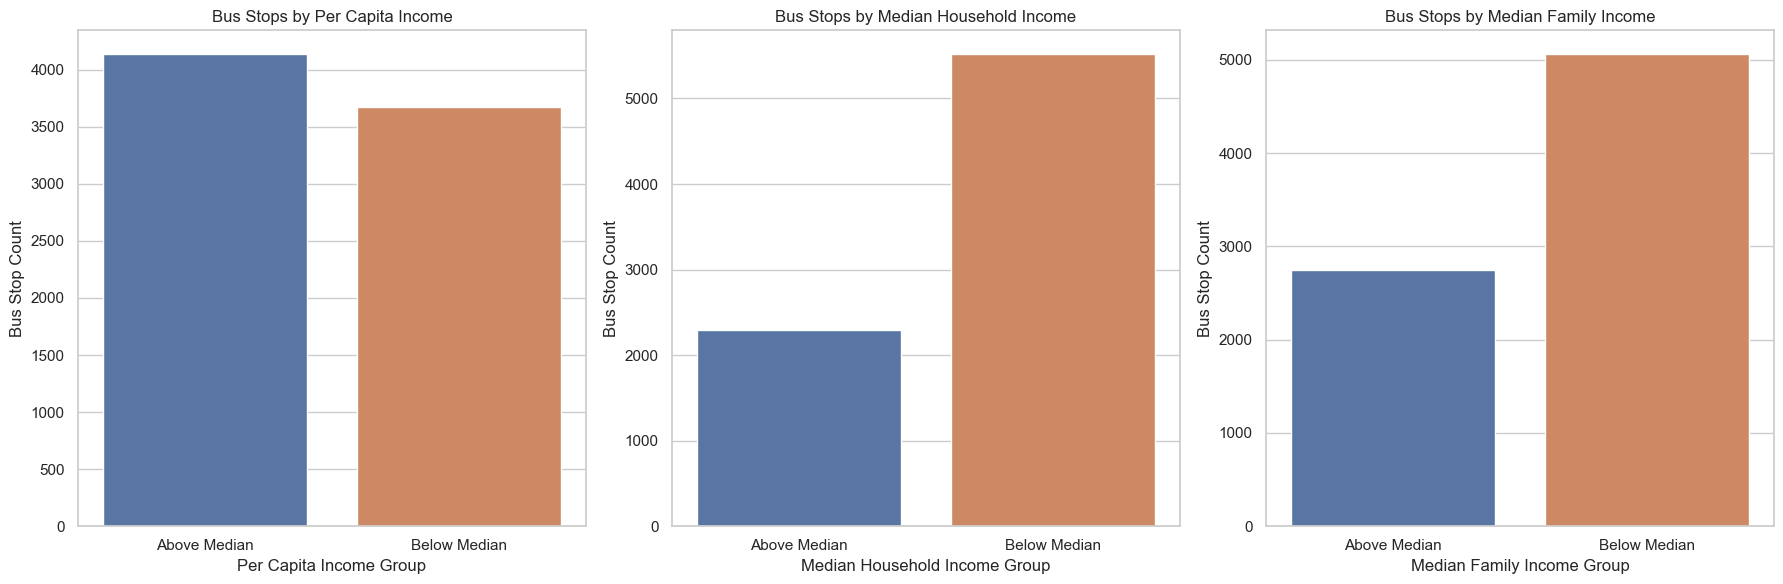

In [22]:
sns.set(style="whitegrid")

# Creating a figure with multiple subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plotting Per Capita Income group
sns.barplot(x='Per Capita Income Group', y='Bus_Stop_Count', data=bus_stops_per_capita_income, ax=axes[0])
axes[0].set_title('Bus Stops by Per Capita Income')
axes[0].set_xlabel('Per Capita Income Group')
axes[0].set_ylabel('Bus Stop Count')

# Plotting Median Household Income group
sns.barplot(x='Median Household Income Group', y='Bus_Stop_Count', data=bus_stops_median_household_income, ax=axes[1])
axes[1].set_title('Bus Stops by Median Household Income')
axes[1].set_xlabel('Median Household Income Group')
axes[1].set_ylabel('Bus Stop Count')

# Plotting Median Family Income group
sns.barplot(x='Median Family Income Group', y='Bus_Stop_Count', data=bus_stops_median_family_income, ax=axes[2])
axes[2].set_title('Bus Stops by Median Family Income')
axes[2].set_xlabel('Median Family Income Group')
axes[2].set_ylabel('Bus Stop Count')

# Adjusting layout
plt.tight_layout()

# Displaying the graphs
plt.show()

In [24]:
cities_data = pd.read_excel(cities_data_path)

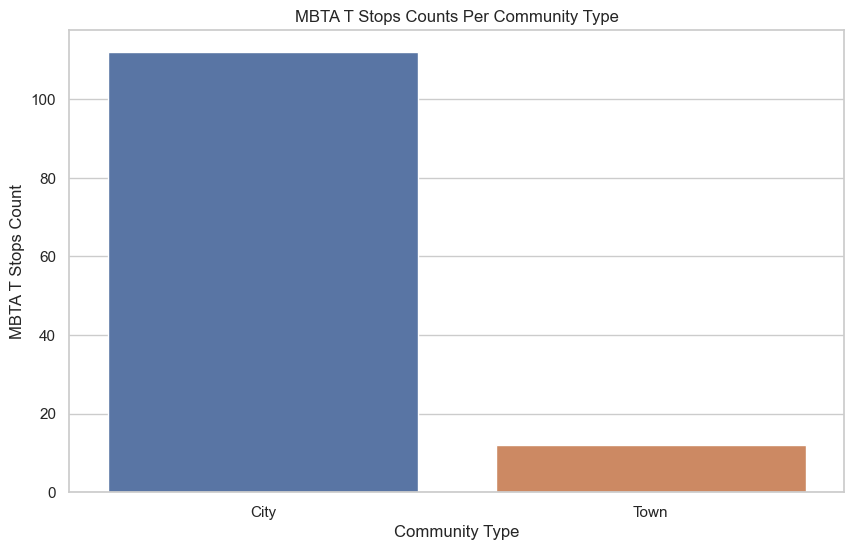

In [25]:
# Extracting the city name from the "City/Neighborhood" column in the MBTA data
mbta_data['City'] = mbta_data['City/Neighborhood'].str.split('/').str[0]

# Counting the number of T stops in each city
mbta_stop_counts = mbta_data['City'].value_counts().reset_index()
mbta_stop_counts.columns = ['Municipality', 'T_Stop_Count']

# Merging this count with the community types data
mbta_merged_data = pd.merge(mbta_stop_counts, cities_data[['Municipality', 'Type']], on='Municipality', how='left')

# Grouping by community type and summing the T stops count
t_stops_per_community_type = mbta_merged_data.groupby('Type')['T_Stop_Count'].sum().reset_index()

# Creating a bar graph for the MBTA T stops counts per community type

# Setting the aesthetics for the graph
sns.set(style="whitegrid")

# Creating the bar graph
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Type', y='T_Stop_Count', data=t_stops_per_community_type)

# Setting the title and labels
plt.title('MBTA T Stops Counts Per Community Type')
plt.xlabel('Community Type')
plt.ylabel('MBTA T Stops Count')

# Displaying the graph
plt.show()